# A simple Bayesian inference tutorial

first import some things we want to use

In [1]:
%pylab --no-import-all inline
import scipy.stats as stats
from mpl_toolkits.mplot3d import axes3d

Populating the interactive namespace from numpy and matplotlib


## Gaussian generative model

The generative model defines two hidden variables $X = [x_1, x_2]^T$ which determine a single observed variable $y$ through a linear model: $y = AX = a_1x_1 + a_2x_2$, i.e., $y$ is a mixture of $x_1$ and $x_2$ where $a_1$ and $a_2$ determine how strongly each $x_i$ influences $y$.

Additionally, there is measurement noise on $y$ such that there is uncertainty on the value of $y$, even when $X$ is known, i.e., $y$ is a random variable and we state its distribution as

$$p(y|X) = N(AX, \sigma^2)$$

where $N(\mu, \sigma^2)$ is the usual way of denominating a Gaussian distribution with mean $\mu$ and variance $\sigma^2$. In our generative model the mean of $y$ is $\mu = AX$. $p(y|X)$ is called the 'likelihood'.

The whole point of the exercise is that $X$ is unknown, but we want to know what its values are. We can express our lack of knowledge in terms of uncertainty over the values of $X$ which again we do through a Gaussian distribution:

$$p(X) = N(\mu_0, \Sigma_0)$$

Because $X$ consists of two variables, $p(X)$ represents a multivariate Gaussian distribution in 2D. Consequently, $\Sigma_0$ is a covariance matrix. You can explore properties of this matrix below. We call $p(X)$ the prior distribution over unknown variables $X$.

## Helper functions

In [2]:
def plot2DGauss3D(ax, mean, cov, cmap=None, vmax=None):
    """This function plots a 2D-Gaussian distribution in a 3D plot."""
    
    mean = np.array(mean).flatten()
    
    step = 0.1
    lim = 10
    levels = np.logspace(np.log10(0.001), np.log10(0.05), 6)
    x1, x2 = np.mgrid[-lim:lim:step, -lim:lim:step]
    pos = np.zeros( x1.shape + (2,) )
    pos[:, :, 0] = x1
    pos[:, :, 1] = x2
    
    vmin = 0
    
    # compute values of multivariate normal density at values in pos
    y = stats.multivariate_normal.pdf( pos, mean, cov )
    
    # plot multivariate density as surface
    srf = ax.plot_surface(x1, x2, y, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor=[0.5, 0.5, 0.5])
    
    # plot marginal densities
    # xbell = ax.plot(x1[:, 0], stats.norm.pdf(x1[:, 0], loc=mean[0], scale=np.sqrt(cov[0, 0])),
    #                 10, zdir='y', color=[0.5, 0.5, 0.5])
    # ybell = ax.plot(x2[0, :], stats.norm.pdf(x2[0, :], loc=mean[1], scale=np.sqrt(cov[1, 1])),
    #                 -10, zdir='x', color=[0.5, 0.5, 0.5])
    
    # plot contours
    cset = ax.contour(x1, x2, y, zdir='x', offset=-10, levels=[mean[0]], colors=([0.5, 0.5, 0.5],))
    cset = ax.contour(x1, x2, y, zdir='y', offset=10, levels=[mean[1]], colors=([0.5, 0.5, 0.5],))
    
    plt.draw()
    

def plot1DGauss(ax, mean, sig2, col=None):
    "This function plots the probability density of a 1D Gaussian distribution."
    
    lim = 10
    x = np.linspace(-lim, lim, 100)
    ax.plot(x, stats.norm.pdf(x, loc=mean, scale=np.sqrt(sig2)), color=col)

## Exploring the multivariate Gaussian distribution in 2D

Below you can change the parameters of the prior distribution. See how this changes the shape and position of the Gaussian distribution! The covariance is specified through two standard deviations and one correlation term. 

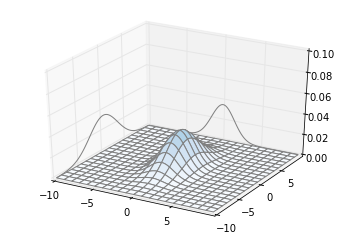

In [3]:
mu0 = np.matrix( [0.0, 0.0] ).transpose()

stdx = 1.5
stdy = 3
corr = 0
Sig0 = np.matrix( [[stdx**2, stdx*stdy*corr],[stdx*stdy*corr, stdy**2]] )

# the highest value that should be considered during plotting
vmax = 0.1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot2DGauss3D(ax, mu0, Sig0, cmap='Blues', vmax=vmax)
ax.set_zlim3d([0, vmax]);

## Sampling from the generative model

It is always a good idea to check what kind of data your generative model predicts. For this simple Gaussian model we can analytically calculate the predictive distribution over $y$, $p(y)$, which is also called the marginal distribution, but often it is much easier to sample from this distribution. We will do both now. Let's start with sampling.

As we don't know the values of $X$, but we do know its prior distribution, we can sample many $X$ from that distribution. Python conveniently provides a function to do that:

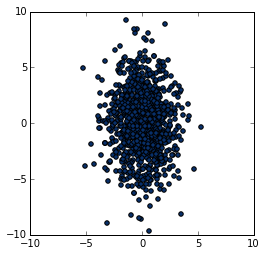

In [4]:
Xsamples = stats.multivariate_normal.rvs(np.array(mu0).flatten(), Sig0, 1000)
ax = plt.axes(aspect='equal')
ax.scatter(Xsamples[:, 0], Xsamples[:, 1], c=plt.cm.Blues(1.0))
ax.set_xlim([-10, 10]);
ax.set_ylim([-10, 10]);

In [15]:
Xsamples.shape

(1000, 2)

## Computing the posterior given one data point

We now observe one data point $y^*$ and want to see how this changes our knowledge of $X$. For that we need to determine the posterior distribution over $X$ through Bayes formula:

$$p(X|y^*) = \frac{p(y^*|X)p(X)}{p(y^*)}.$$

There are several ways of figuring out what the posterior distribution should be. The easiest is to simply look it up for this simple case of a completely Gaussian generative model. For example in [Chris Bishop's book](http://research.microsoft.com/en-us/um/people/cmbishop/prml/index.htm) (p. 93) we find that the posterior distribution is again Gaussian and depends on the means and covariances of the likelihood and prior such that

$$p(X|y^*) = N(\mu^*, \Sigma^*)$$

with

$$\Sigma^* = (\Sigma_0^{-1} + A^TA / \sigma^2)^{-1}$$
$$\mu^* = \Sigma^*(A^Ty^*/\sigma^2 + \Sigma_0^{-1}\mu_0)$$

There are a few things to note:
1. The posterior uncertainty is lower than the prior uncertainty. This is because we add $A^TA / \sigma^2$ to the inverse of the prior uncertainty, i.e., the prior precision, and then invert the result to get the posterior uncertainty.
2. Information from $y$-space is transferred to $X$-space through the connecting matrix $A$.
3. The posterior mean depends on the observed data $y^*$, but also on the prior mean $\mu_0$. Both are modulated by the inverse of their respective uncertainties. Therefore, the posterior mean will tend to the one which is more certain.

The following function implements the computation of the posterior and returns $\mu^*$, $\Sigma^*$.

In [5]:
def computePosterior(ystar, mu0, Sig0, sig2, A):
    priprec = np.linalg.inv(Sig0)
    likprec = 1 / sig2
    Sigstar = np.linalg.inv( priprec + A.transpose() * likprec * A )
    
    return Sigstar * ( A.transpose() * likprec * ystar + priprec * mu0 ), Sigstar

We will now see how the prior gets updated to the posterior. There will be three plots. On the left we repeat the prior, in the middle we plot the likelihood for $X=\mu_0$ to see how much measurement noise the generative model expects together with the observed data value $y^*$ and on the right you'll see the posterior distribution over $X$.

posterior means = [ 0.82,  0.82]
posterior stds  = [ 2.31,  2.31]
posterior corr  = -0.41


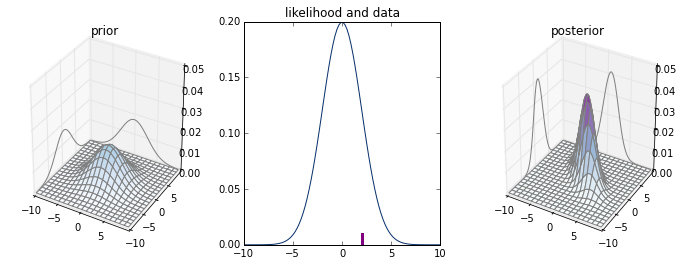

In [6]:
# define prior
mu0 = np.matrix( [0.0, 0.0] ).transpose()

stdx = 3
stdy = 3
corr = 0
Sig0 = np.matrix( [[stdx**2, stdx*stdy*corr],[stdx*stdy*corr, stdy**2]] )

# define likelihood
sig2 = 2.0**2
A = np.matrix([1, 1])

# choose observed data point
ystar = 2.0

# figure
fig = plt.figure(figsize=(12, 4))
vmax = 0.05

# plot prior
ax1 = fig.add_subplot(131, projection='3d')
plot2DGauss3D(ax1, mu0, Sig0, cmap='Blues', vmax=vmax)
ax1.set_zlim3d([0, vmax]);
ax1.set_title('prior')

# plot likelihood and data
ax2 = fig.add_subplot(132)
plot1DGauss(ax2, (A*mu0)[0, 0], sig2, col=plt.cm.Blues(1.0))
ax2.plot([ystar, ystar], [0.0, 0.01], color='purple', linewidth=3)
ax2.set_title('likelihood and data')

# plot posterior
mustar, Sigstar = computePosterior(ystar, mu0, Sig0, sig2, A)
ax3 = fig.add_subplot(133, projection='3d')
plot2DGauss3D(ax3, mustar, Sigstar, cmap='BuPu', vmax=vmax)
ax3.set_zlim3d([0, vmax]);
ax3.set_title('posterior')

# print posterior mean and covariance for reference
pstdx = np.sqrt(Sigstar[0, 0])
pstdy = np.sqrt(Sigstar[1, 1])
print 'posterior means = [%5.2f, %5.2f]' % (mustar[0, 0], mustar[1, 0])
print 'posterior stds  = [%5.2f, %5.2f]' % (pstdx, pstdy)
print 'posterior corr  = %5.2f' % (Sigstar[0, 1] / stdx / stdy,)